Work by Anna Kudela and Weronika Wojtkowiak

# 10-Year Breakeven Inflation Rate (T10YIE)
The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.
Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department.



*   **Units**:  Percent, Not Seasonally Adjusted
*   **Frequency**:  Daily
*   **Source**: [Federal Reserve Bank of St. Louis](http://www.stlouisfed.org/)



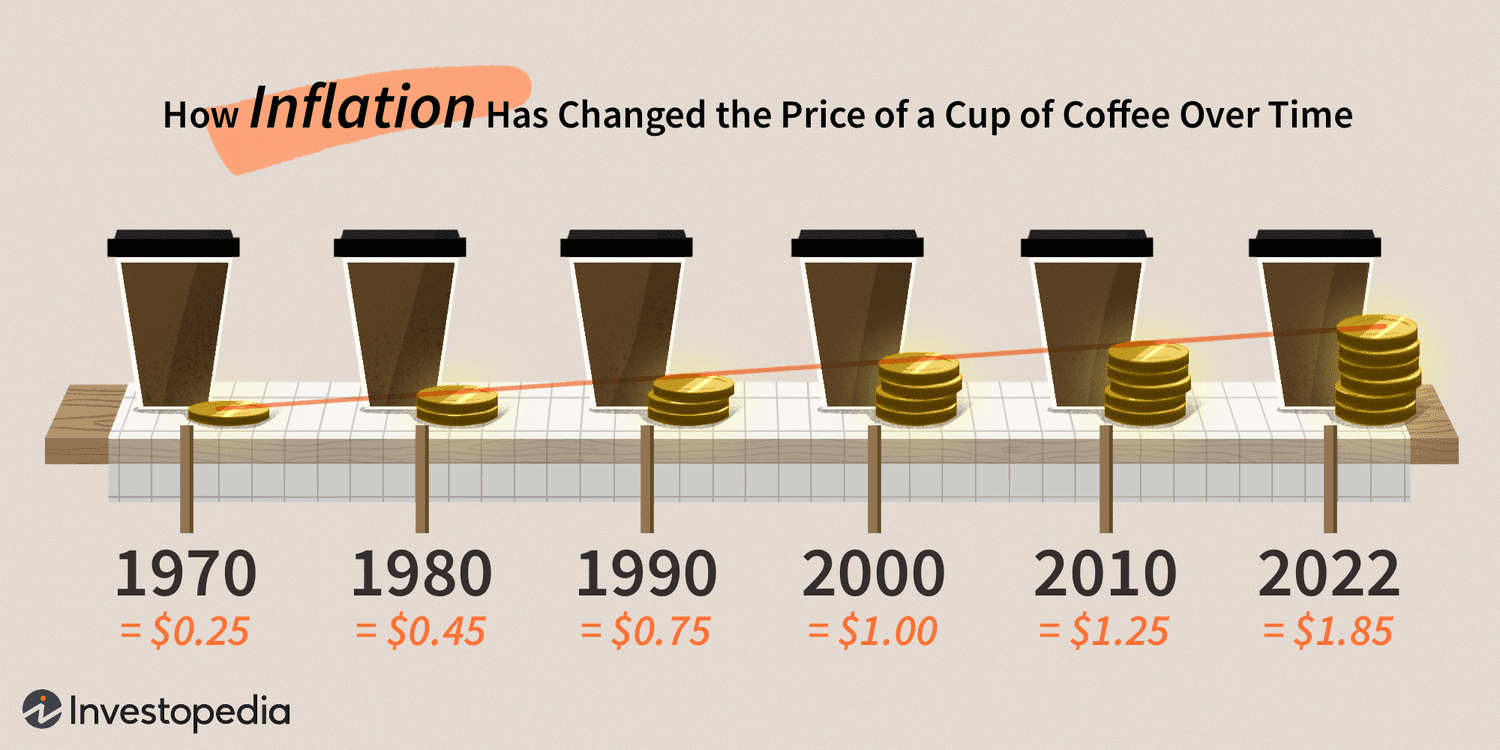

In [ ]:
pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from itertools import product

from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from prophet import Prophet
from pmdarima import auto_arima
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/TimeSeries')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/TimeSeries/T10YIE.csv')

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE').asfreq('B')

df.index.names = ['Date']

df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df

,T10YIE
Date,
2018-06-25,2.10
2018-06-26,2.12
2018-06-27,2.11
2018-06-28,2.10
2018-06-29,2.11
...,...
2023-06-16,2.22
2023-06-20,2.22
2023-06-21,2.21


<Axes: xlabel='Date'>

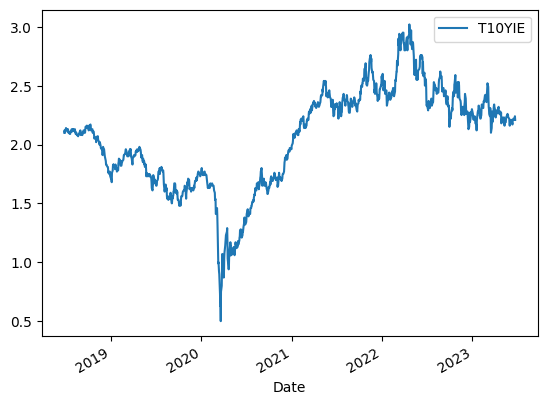

In [ ]:
df.plot()

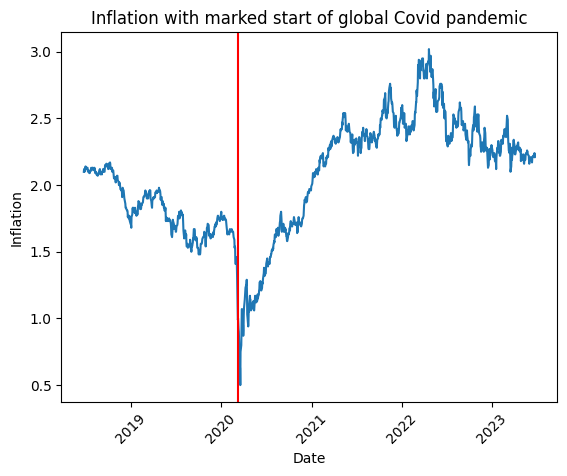

In [ ]:
plt.plot(df.index, df['T10YIE'])
target_date = pd.to_datetime('2020-03-11')
plt.axvline(target_date, color='red')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.title('Inflation with marked start of global Covid pandemic')
plt.xticks(rotation=45)
plt.show()

In [ ]:
adfuller(df)  # null hypothesis time series is non-stationary

(-1.639951227448115,
 0.46228627801811045,
 1,
 1248,
 {'1%': -3.4356006420838963,
  '5%': -2.8638586845641063,
  '10%': -2.5680044958343604},
 -4591.255920184336)

In [ ]:
kpss(df)  # null hypothesis time series is stationary

(3.050358043678856,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Both tests indicate that time series is non-stationary

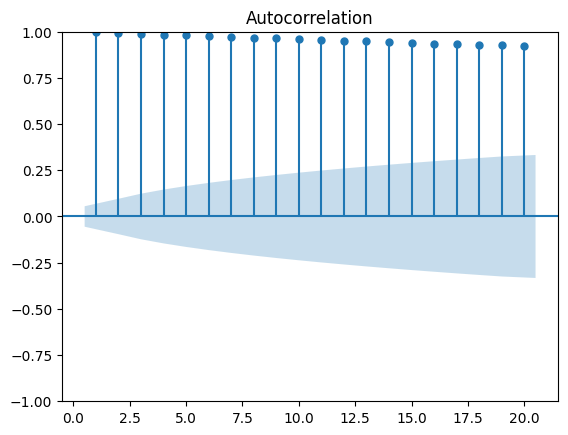

In [ ]:
plot_acf(df, lags=20, zero=False);

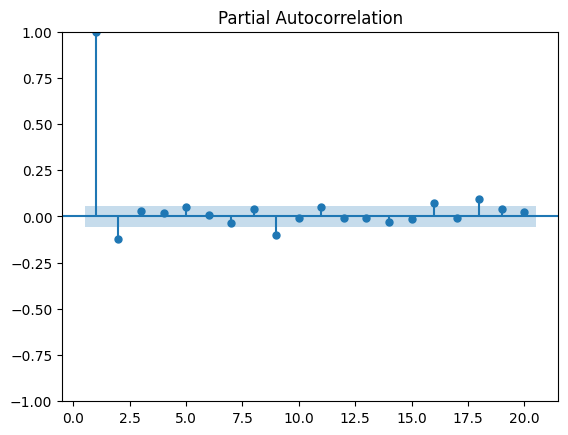

In [ ]:
plot_pacf(df, lags=20, zero=False);

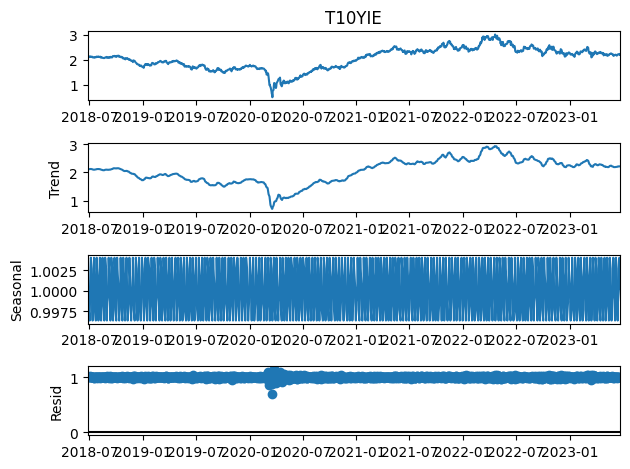

In [ ]:
seasonalDecompose = seasonal_decompose(df['T10YIE'], model='mul', period=7)
seasonalDecompose.plot();

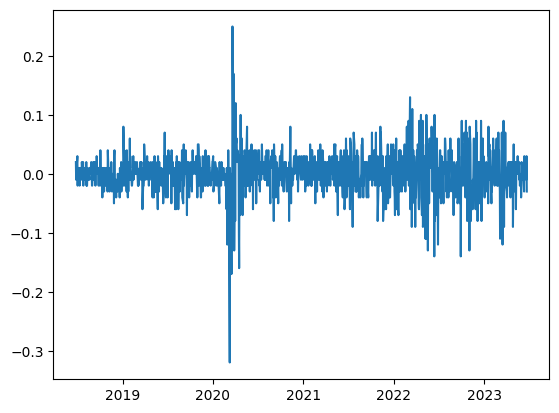

In [ ]:
drift_data = df['T10YIE'].diff()
plt.plot(drift_data)

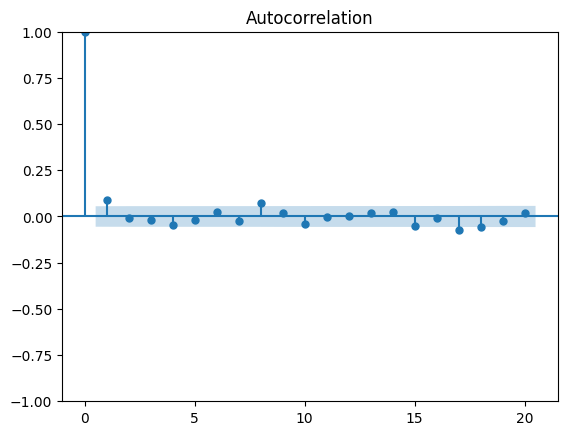

In [ ]:
fig=plot_acf(drift_data.dropna(),lags=20,zero=True)

In [ ]:
adfuller(drift_data.dropna())

(-32.22524455934591,
 0.0,
 0,
 1248,
 {'1%': -3.4356006420838963,
  '5%': -2.8638586845641063,
  '10%': -2.5680044958343604},
 -4585.922551233072)

In [ ]:
kpss(drift_data.dropna())

(0.0993014038414416,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Both tests indicate that time series is stationary

In [ ]:
train = df.iloc[:1000]
test = df.iloc[1000:]

In [ ]:
test

,T10YIE
Date,
2022-06-24,2.56
2022-06-27,2.55
2022-06-28,2.48
2022-06-29,2.36
2022-06-30,2.33
...,...
2023-06-16,2.22
2023-06-20,2.22
2023-06-21,2.21


## Exponential Smoothing

In [ ]:
def model(trend_type, seasonal_type):
  fit_ES = ExponentialSmoothing(train, trend=trend_type,
  seasonal=seasonal_type, seasonal_periods=360).fit()
  test_predictions = fit_ES.forecast(len(test)+12)
  new_dates = pd.date_range(start=test.index[-1], periods=13, freq='D')[1:]
  # Create a new DataFrame with the new dates as the index and 0 values
  new_rows = pd.DataFrame(0, index=new_dates, columns=df.columns)
  # Concatenate the existing DataFrame with the new rows
  updated_df = pd.concat([test, new_rows])
  updated_df['pred']= test_predictions.values
  return updated_df['pred']

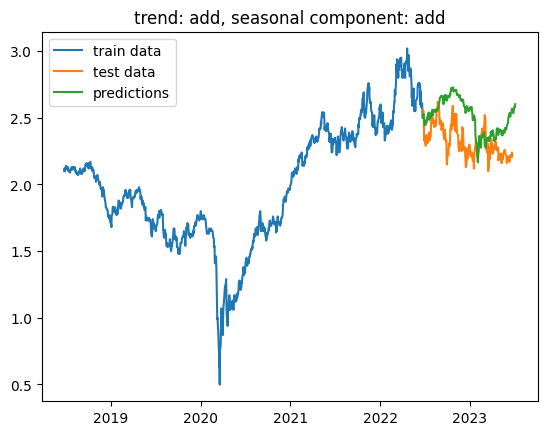

Mean squared error:  0.051228011751076295


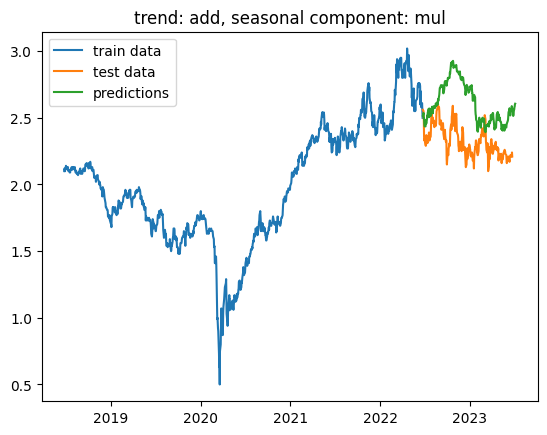

Mean squared error:  0.10487214043829794


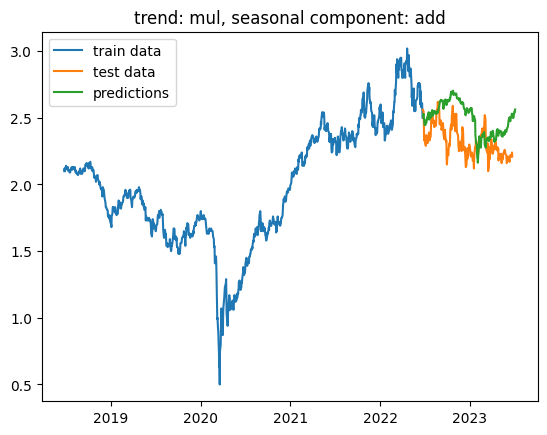

Mean squared error:  0.044599367708810504


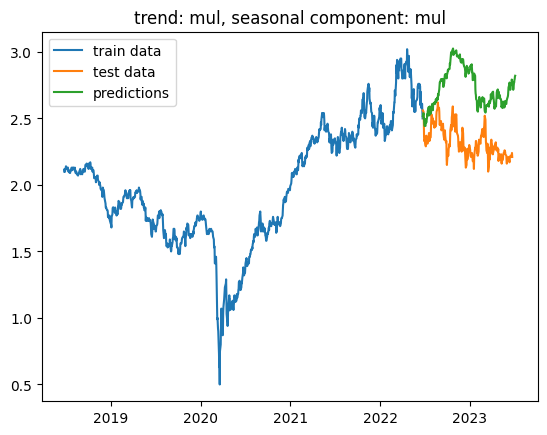

Mean squared error:  0.19277279538628742


In [ ]:
components = ['add', 'mul']
for trend_type, seasonal_type in product(components, repeat=2):
  plt.plot(figsize=(12,8))
  plt.plot(train, label='train data')
  plt.plot(test, label='test data')
  pre = model(trend_type=trend_type, seasonal_type=seasonal_type)
  plt.plot(pre, label='predictions')
  plt.title(f'trend: {trend_type}, seasonal component: {seasonal_type}')
  plt.legend()
  plt.show()
  print('Mean squared error: ', mean_squared_error(test.values, pre[:len(pre)-12].values))

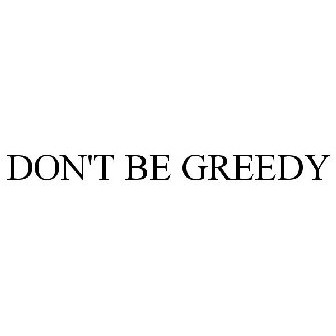

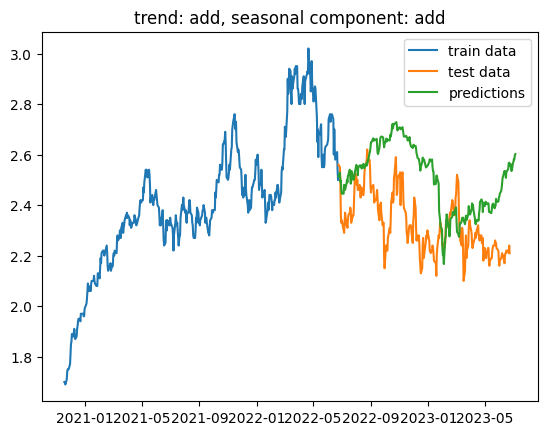

Mean squared error:  0.051228011751076295


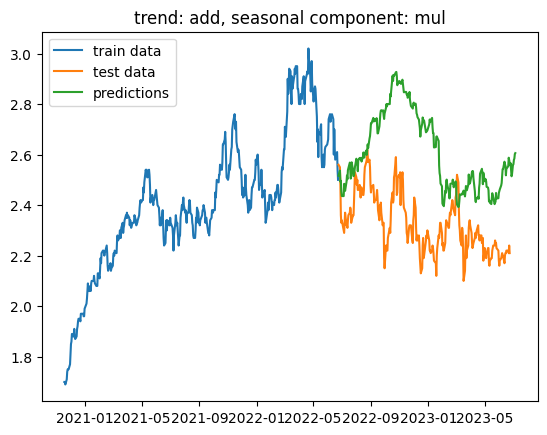

Mean squared error:  0.10487214043829794


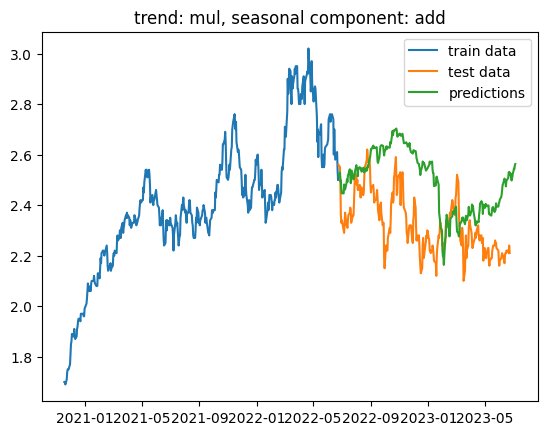

Mean squared error:  0.044599367708810504


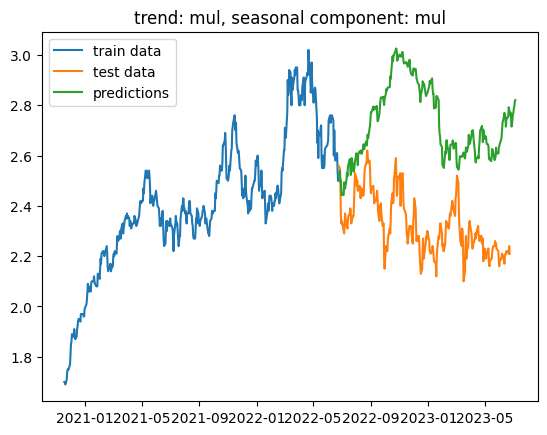

Mean squared error:  0.19277279538628742


In [ ]:
components = ['add', 'mul']
for trend_type, seasonal_type in product(components, repeat=2):
  plt.plot(figsize=(12,8))
  plt.plot(train[600:], label='train data')
  plt.plot(test, label='test data')
  pre = model(trend_type=trend_type, seasonal_type=seasonal_type)
  plt.plot(pre, label='predictions')
  plt.title(f'trend: {trend_type}, seasonal component: {seasonal_type}')
  plt.legend()
  plt.show()
  print('Mean squared error: ', mean_squared_error(test.values, pre[:len(pre)-12].values))

# ARIMA

In [ ]:
auto_arima(train, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3802.837, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3798.369, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3802.147, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3801.712, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3800.246, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3799.946, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3799.698, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3803.376, Time=1.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3797.809, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-3800.695, Time=2.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3797.513, Time=2.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3803.147, Time=3.81 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-3802.433, Time=1.17 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-3798.872, Time=4.35 sec
 ARIMA(3,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1910.206
Date:                Mon, 26 Jun 2023   AIC                          -3810.411
Time:                        14:13:48   BIC                          -3785.878
Sample:                             0   HQIC                         -3801.086
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0667      0.052     20.606      0.000       0.965       1.168
ar.L2         -0.8808      0.042    -21.075      0.000      -0.963      -0.799
ma.L1         -1.0077      0.052    -19.382      0.000      -1.110      -0.906
ma.L2          0.8719      0.042     20.540      0.000       0.789       0.955
sigma2         0.0013   2.94e-05     43.463      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3983.62
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               3.37   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model1 = ARIMA(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit()
model1.summary()
start = len(train)
end = len(train)+len(test)-1
predictions1 = model1.predict(start=start,end=end).rename('SARIMA(0,1,1)(0,0,0,0) Predictions')

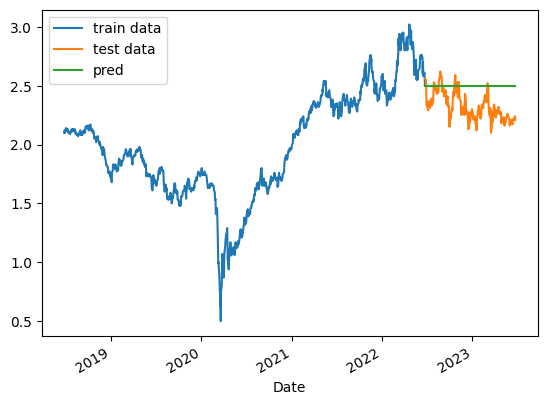

In [ ]:
plt.plot(train, label='train data')
plt.plot(test['T10YIE'], label='test data')
test['pred']= predictions1.values
test['pred'].plot(legend=True)
plt.legend()

# SARIMA

In [ ]:
auto_arima(train, seasonal=True, trace=True, m=30).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=-3797.952, Time=21.10 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-3798.369, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-3801.271, Time=3.78 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-3801.005, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-3800.246, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=-3802.147, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=-3801.388, Time=4.11 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=11.57 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=-3801.683, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=-3800.476, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=-3801.712, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=-3799.698, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[30]             : AIC=-3804.042, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[30]             : AIC=-3803.175, Time=1.02 sec
 ARIMA(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1904.021
Date:                Sat, 24 Jun 2023   AIC                          -3804.042
Time:                        19:44:38   BIC                          -3794.229
Sample:                             0   HQIC                         -3800.312
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0761      0.019      4.039      0.000       0.039       0.113
sigma2         0.0013   2.37e-05     54.591      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4306.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model1 = SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,30)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 T10YIE   No. Observations:                 1000
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1904.021
Date:                Sat, 24 Jun 2023   AIC                          -3804.042
Time:                        19:45:00   BIC                          -3794.229
Sample:                             0   HQIC                         -3800.312
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0761      0.019      4.039      0.000       0.039       0.113
sigma2         0.0013   2.37e-05     54.591      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4306.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(train)
end = len(train)+len(test)-1
predictions1 = model1.predict(start=start,end=end).rename('SARIMA(1,1,0)(0,0,0,30) Predictions')

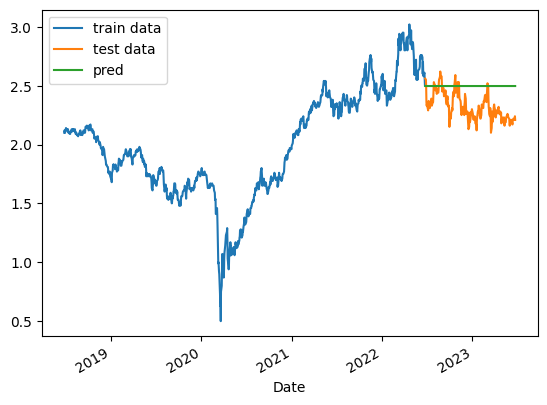

In [ ]:
plt.plot(train, label='train data')
plt.plot(test['T10YIE'], label='test data')
test['pred']= predictions1.values
test['pred'].plot(legend=True)
plt.legend()

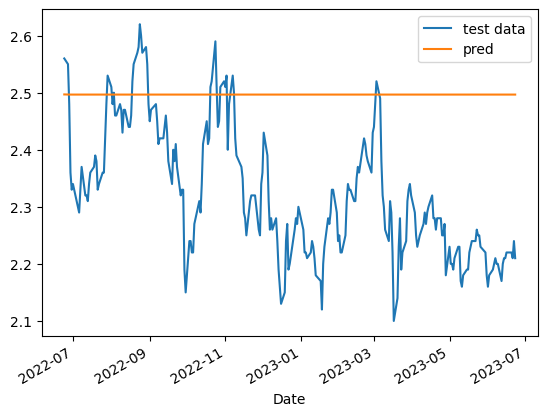

In [ ]:
plt.plot(test['T10YIE'], label='test data')
test['pred']= predictions1.values
test['pred'].plot(legend=True)
plt.legend()

In [ ]:
auto_arima(train, seasonal=True, trace=True, m=7).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-3800.258, Time=4.95 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-3798.369, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-3802.197, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-3801.550, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-3800.246, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-3802.147, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-3801.623, Time=2.08 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-3805.804, Time=2.68 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-3802.044, Time=0.80 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-3799.838, Time=1.93 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-3799.554, Time=2.66 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-3801.573, Time=2.27 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=-3797.979, Time=5.49 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-3795.206, Time=1.05 sec
 ARIMA(2,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood                1908.848
Date:                             Sat, 24 Jun 2023   AIC                          -3807.695
Time:                                     19:47:51   BIC                          -3783.161
Sample:                                          0   HQIC                         -3798.370
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.019      4.084      0.000       0.041       0.117
ar.L2          0.0448      0.021      2.148      0.032       0.004       0.086
ar.S.L7       -0.9581      0.046    -20.640      0.000      -1.049      -0.867
ma.S.L7        0.9290      0.055     16.938      0.000       0.821       1.036
sigma2         0.0013   2.44e-05     52.603      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4193.79
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model2 = SARIMAX(train, order=(2,1,0), seasonal_order=(1,0,1,7)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              T10YIE   No. Observations:                 1000
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood                1908.848
Date:                             Sat, 24 Jun 2023   AIC                          -3807.695
Time:                                     19:48:51   BIC                          -3783.161
Sample:                                          0   HQIC                         -3798.370
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.019      4.084      0.000       0.041       0.117
ar.L2          0.0448      0.021      2.148      0.032       0.004       0.086
ar.S.L7       -0.9581      0.046    -20.640      0.000      -1.049      -0.867
ma.S.L7        0.9290      0.055     16.938      0.000       0.821       1.036
sigma2         0.0013   2.44e-05     52.603      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4193.79
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(train)
end = len(train)+len(test)-1
predictions2 = model2.predict(start=start,end=end).rename('SARIMA(2,1,0)(1,0,1,7) Predictions')

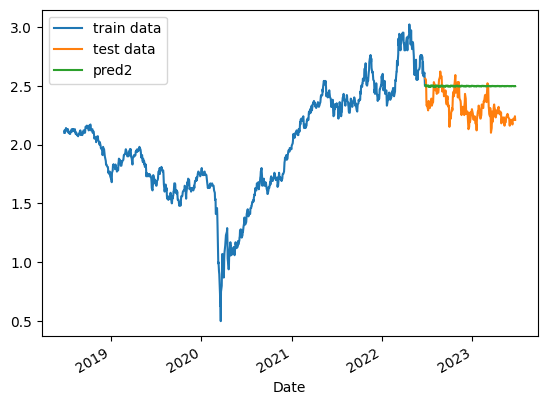

In [ ]:
plt.plot(train, label='train data')
plt.plot(test['T10YIE'], label='test data')
test['pred2']= predictions2.values
test['pred2'].plot(legend=True)
plt.legend()

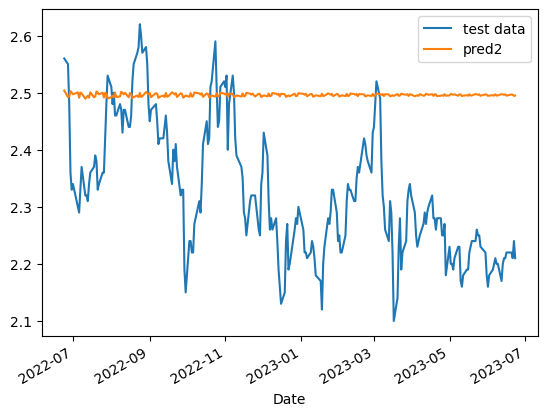

In [ ]:
plt.plot(test['T10YIE'], label='test data')
test['pred2']= predictions2.values
test['pred2'].plot(legend=True)
plt.legend()

In [ ]:
auto_arima(train, seasonal=True, trace=True, m=3).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=-3796.531, Time=4.52 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=-3798.369, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=-3800.459, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=-3800.006, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=-3800.246, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[3] intercept   : AIC=-3802.147, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[3] intercept   : AIC=-3800.451, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[3] intercept   : AIC=-3798.416, Time=0.96 sec
 ARIMA(2,1,0)(0,0,0)[3] intercept   : AIC=-3801.683, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=-3800.476, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept   : AIC=-3801.712, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[3] intercept   : AIC=-3799.698, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[3]             : AIC=-3804.042, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[3]             : AIC=-3802.352, Time=0.49 sec
 ARIMA(1,1,0)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1904.021
Date:                Sat, 24 Jun 2023   AIC                          -3804.042
Time:                        19:56:35   BIC                          -3794.229
Sample:                             0   HQIC                         -3800.312
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0761      0.019      4.039      0.000       0.039       0.113
sigma2         0.0013   2.37e-05     54.591      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4306.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

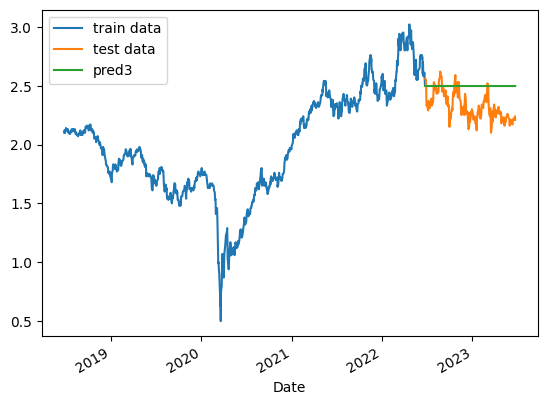

In [ ]:
model3 = SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,3)).fit()
model3.summary()
start = len(train)
end = len(train)+len(test)-1
predictions3 = model3.predict(start=start,end=end).rename('SARIMA(2,1,0)(1,0,1,7) Predictions')
plt.plot(train, label='train data')
plt.plot(test['T10YIE'], label='test data')
test['pred3']= predictions3.values
test['pred3'].plot(legend=True)
plt.legend()

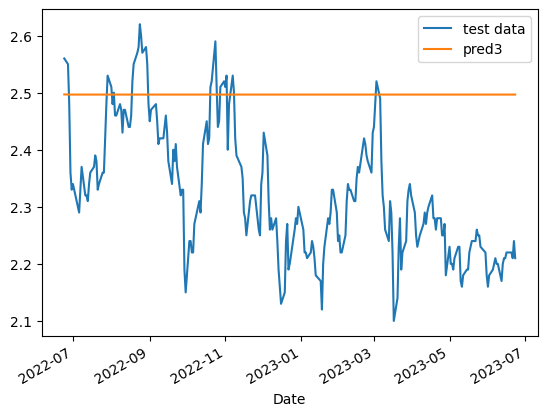

In [ ]:
plt.plot(test['T10YIE'], label='test data')
test['pred3']= predictions3.values
test['pred3'].plot(legend=True)
plt.legend()

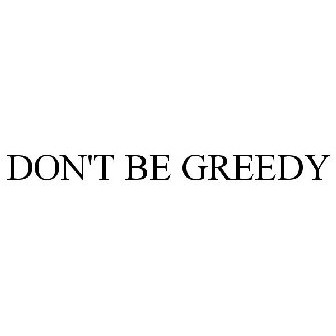

In [ ]:
auto_arima(train[-360:], seasonal=True, trace=True, m=100).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[100] intercept   : AIC=-1289.785, Time=66.71 sec
 ARIMA(0,1,0)(0,0,0)[100] intercept   : AIC=-1296.475, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[100] intercept   : AIC=-1292.515, Time=12.83 sec
 ARIMA(0,1,1)(0,0,1)[100] intercept   : AIC=-1292.523, Time=18.60 sec
 ARIMA(0,1,0)(0,0,0)[100]             : AIC=-1298.190, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[100] intercept   : AIC=-1294.490, Time=9.09 sec
 ARIMA(0,1,0)(0,0,1)[100] intercept   : AIC=-1294.492, Time=17.86 sec
 ARIMA(0,1,0)(1,0,1)[100] intercept   : AIC=-1292.494, Time=10.66 sec
 ARIMA(1,1,0)(0,0,0)[100] intercept   : AIC=-1294.498, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[100] intercept   : AIC=-1294.504, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[100] intercept   : AIC=-1295.471, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[100]          
Total fit time: 136.571 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 650.095
Date:                Sat, 24 Jun 2023   AIC                          -1298.190
Time:                        20:06:36   BIC                          -1294.307
Sample:                             0   HQIC                         -1296.646
                                - 360                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0016   9.73e-05     16.086      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                13.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.86   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

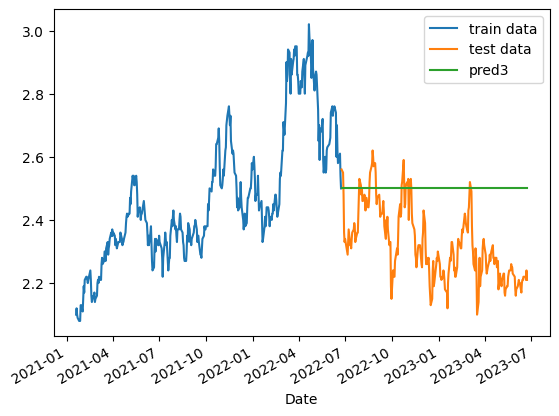

In [ ]:
model3 = SARIMAX(train[-360:], order=(0,1,0), seasonal_order=(0,0,0,100)).fit()
model3.summary()
start = len(train)
end = len(train)+len(test)-1
predictions3 = model3.predict(start=start,end=end).rename('SARIMA(2,1,0)(1,0,1,7) Predictions')
plt.plot(train[-360:], label='train data')
plt.plot(test['T10YIE'], label='test data')
test['pred3']= predictions3.values
test['pred3'].plot(legend=True)
plt.legend()

ARIMA (weekly df)

In [ ]:
weekly_df = df.resample('W').mean()
weekly_df

,T10YIE
Date,
2018-07-01,2.1080
2018-07-08,2.1275
2018-07-15,2.1160
2018-07-22,2.0960
2018-07-29,2.1160
...,...
2023-05-28,2.2460
2023-06-04,2.1850
2023-06-11,2.2000


<Axes: xlabel='Date'>

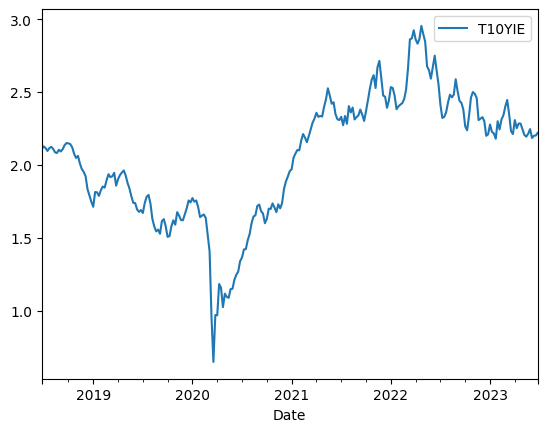

In [ ]:
weekly_df.plot()

In [ ]:
train_W = weekly_df.iloc[:-51]
test_W = weekly_df.iloc[-51:]

In [ ]:
auto_arima(train_W, seasonal=True, trace=True, m=51).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[51] intercept   : AIC=-509.260, Time=15.78 sec
 ARIMA(0,1,0)(0,0,0)[51] intercept   : AIC=-502.183, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[51] intercept   : AIC=-508.519, Time=2.86 sec
 ARIMA(0,1,1)(0,0,1)[51] intercept   : AIC=-507.910, Time=2.75 sec
 ARIMA(0,1,0)(0,0,0)[51]             : AIC=-504.098, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[51] intercept   : AIC=-511.253, Time=12.87 sec
 ARIMA(2,1,2)(0,0,0)[51] intercept   : AIC=-513.238, Time=0.50 sec
 ARIMA(2,1,2)(1,0,0)[51] intercept   : AIC=-511.259, Time=12.79 sec
 ARIMA(1,1,2)(0,0,0)[51] intercept   : AIC=-506.734, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[51] intercept   : AIC=-506.333, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[51] intercept   : AIC=-509.587, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[51] intercept   : AIC=-511.216, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[51] intercept   : AIC=-508.324, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[51] intercept   : AIC=-505.503, Time=0.82 sec
 ARIMA(3,1,1)(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 262.579
Date:                Sat, 24 Jun 2023   AIC                           -515.159
Time:                        20:14:29   BIC                           -498.447
Sample:                    07-01-2018   HQIC                          -508.402
                         - 07-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7349      0.136      5.385      0.000       0.467       1.002
ar.L2         -0.7531      0.106     -7.074      0.000      -0.962      -0.544
ma.L1         -0.5353      0.134     -3.985      0.000      -0.799      -0.272
ma.L2          0.7100      0.130      5.473      0.000       0.456       0.964
sigma2         0.0047      0.000     22.381      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               857.07
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.77   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

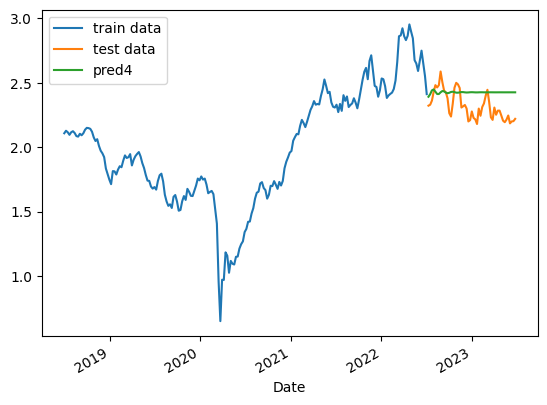

In [ ]:
model4 = SARIMAX(train_W, order=(2,1,2), seasonal_order=(0,0,0,51)).fit()
model4.summary()
start = len(train_W)
end = len(train_W)+len(test_W)-1
predictions4 = model4.predict(start=start,end=end).rename('SARIMA(2,1,2)(0,0,0,51) Predictions')
plt.plot(train_W, label='train data')
plt.plot(test_W['T10YIE'], label='test data')
test_W['pred4']= predictions4.values
test_W['pred4'].plot(legend=True)
plt.legend()

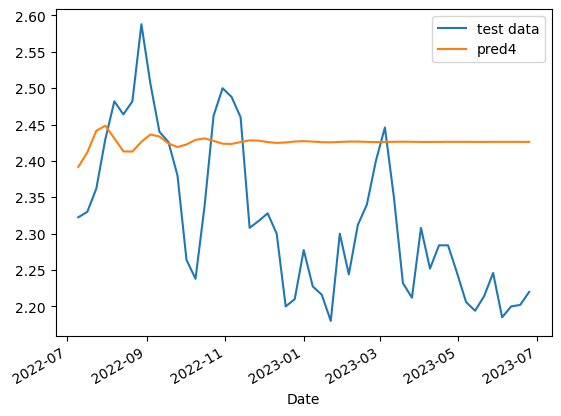

In [ ]:
plt.plot(test_W['T10YIE'], label='test data')
test_W['pred4']= predictions4.values
test_W['pred4'].plot(legend=True)
plt.legend()

## Prophet

In [ ]:
prophet_df = pd.DataFrame()
prophet_df["ds"] = df.index
prophet_df["y"] = df.values
prophet_df

,ds,y
0,2018-06-25,2.10
1,2018-06-26,2.12
2,2018-06-27,2.11
3,2018-06-28,2.10
4,2018-06-29,2.11
...,...,...
1245,2023-06-16,2.22
1246,2023-06-20,2.22
1247,2023-06-21,2.21
1248,2023-06-22,2.24


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu6me8im3/ods3awom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu6me8im3/vikwao4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63482', 'data', 'file=/tmp/tmpu6me8im3/ods3awom.json', 'init=/tmp/tmpu6me8im3/vikwao4q.json', 'output', 'file=/tmp/tmpu6me8im3/prophet_model6uo0on7r/prophet_model-20230624195318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


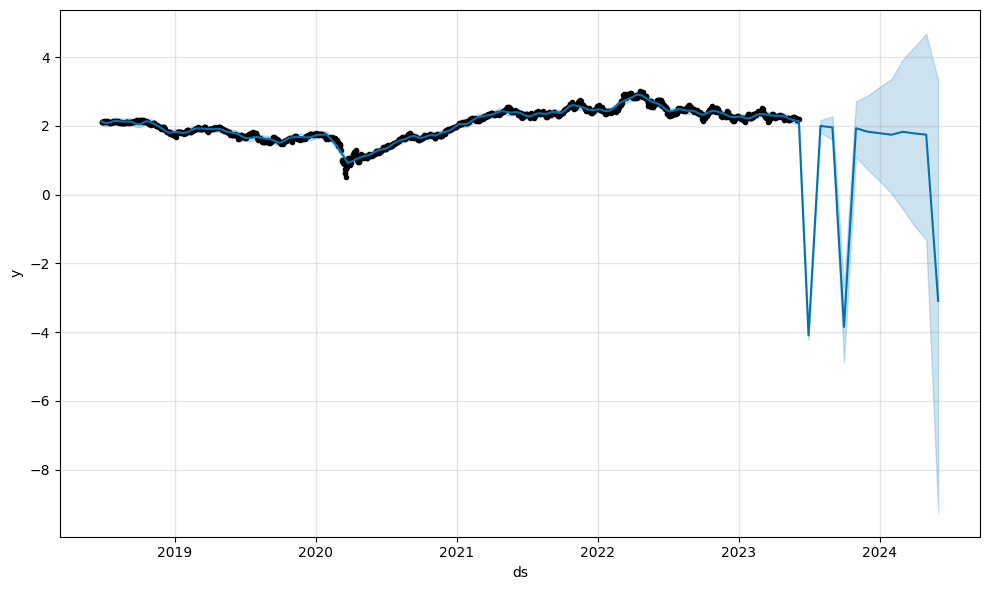

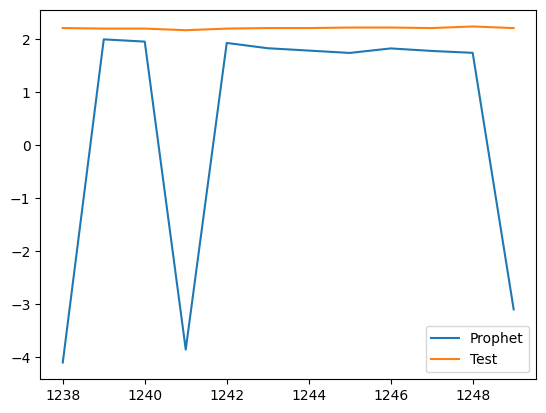

In [ ]:
train_prophet = prophet_df[:-12]
test_prophet = prophet_df[-12:]

prophet = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
prophet.fit(train_prophet)

future = prophet.make_future_dataframe(periods=12, freq="MS")
forecast = prophet.predict(future)

prophet.plot(forecast)

plt.figure()
plt.plot(forecast["yhat"][-12:], label="Prophet")
plt.plot(test_prophet["y"], label="Test")
plt.legend()

## LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 250
X, y = create_sequences(scaled_data, sequence_length)

# Train-Test Split
X_train, X_test = X[:-250], X[-250:]
y_train, y_test = y[:-250], y[-250:]

# Model Architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


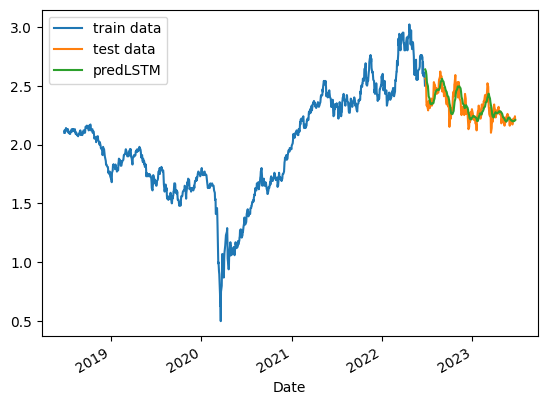

In [ ]:
start = len(train)
end = len(train)+len(test)-1
plt.plot(train, label='train data')
plt.plot(test['T10YIE'], label='test data')
test['predLSTM']= predictions
test['predLSTM'].plot(legend=True)
plt.legend()

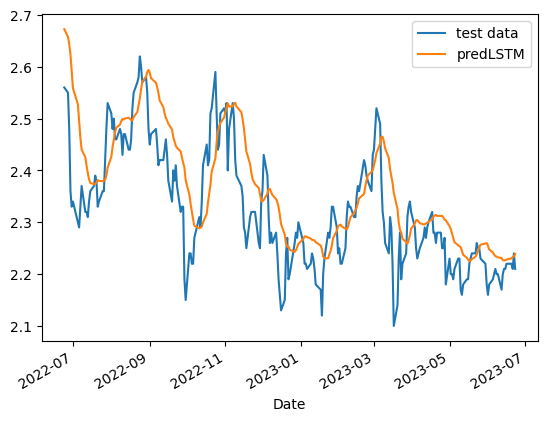

In [ ]:
plt.plot(test['T10YIE'], label='test data')
test['predLSTM']= predictions
test['predLSTM'].plot(legend=True)
plt.legend()

In [ ]:
y_train.shape
X_train.shape

(800, 250)

In [ ]:
print('Mean squared error: ', mean_squared_error(test['T10YIE'].values, test['predLSTM'].values))

Mean squared error:  0.0072986334122212854


# LSTM

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
train=df.iloc[:len(df)-14]
test=df.iloc[len(df)-14:]
scaler=MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)
n_input=12
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)
X,y=generator[0]
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(generator,epochs=10)

In [ ]:
first_eval_batch=scaled_train[-12:]
first_eval_batch=first_eval_batch.reshape((1,n_input,1))
model.predict(first_eval_batch)

1/1 [==============================] - 0s 171ms/step


array([[0.68382174]], dtype=float32)

In [ ]:
test_predictions=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,1))

for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

<Axes: xlabel='Date'>

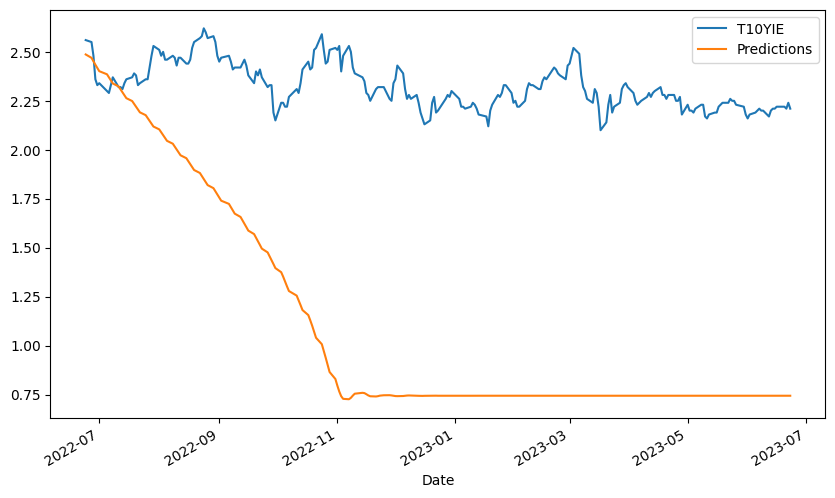

In [ ]:
true_predictions=scaler.inverse_transform(test_predictions)
test['Predictions']=true_predictions
test.plot(figsize=(10,6))

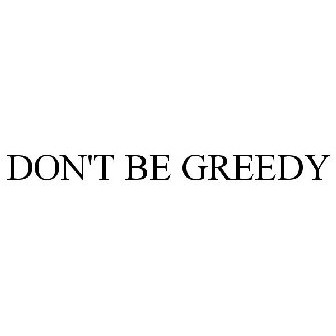

<Axes: xlabel='Date'>

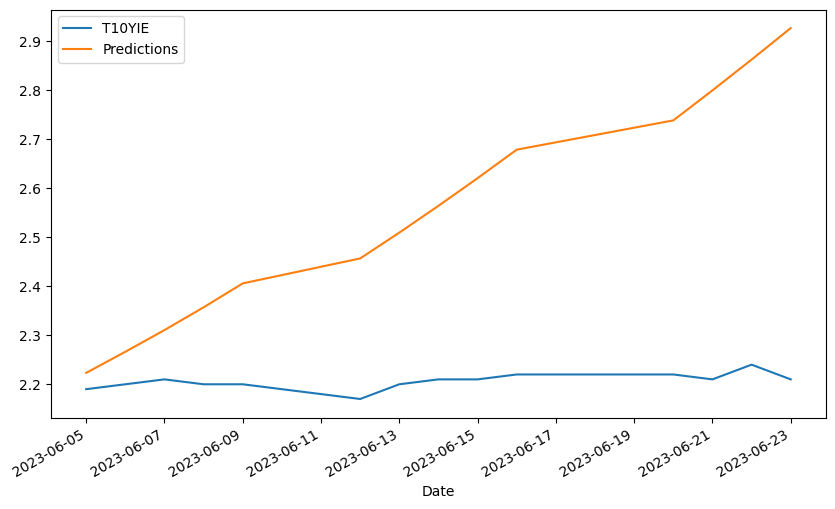

In [ ]:
true_predictions=scaler.inverse_transform(test_predictions)
test['Predictions']=true_predictions
test.plot(figsize=(10,6))

## Random Forest

In [ ]:
df_rf=df.copy()
for i in range(250,0,-1):
 print(i)
 df_rf['t='+str(i)]=df_rf['T10YIE'].shift(i)

In [ ]:
df_rf.dropna(inplace=True)
df_rf

In [ ]:
y=df_rf.iloc[:,0].values
y.shape

(1000,)

In [ ]:
X=df_rf.iloc[:,1:].values
X.shape

(1000, 250)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xg

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
rfr=RandomForestRegressor(random_state=42,n_estimators=200,max_features=10)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_features=10, n_estimators=200, random_state=42)

In [ ]:
def get_first_eval_batch(data,n):
 return data[-n:].reshape(-1,n)

train=df[:-250]
test=df[-250:]

In [ ]:
n_lag=250
test_prediction_rfr=[]
current_batch=get_first_eval_batch(train['T10YIE'].values,n_lag)
for i in range(len(test)):
 current_pred=rfr.predict(current_batch)[0]
 test_prediction_rfr.append(current_pred)
 current_batch=np.append(current_batch[:,1:],current_pred).reshape(-1,n_lag)
 test_prediction_rfr

<Axes: xlabel='Date'>

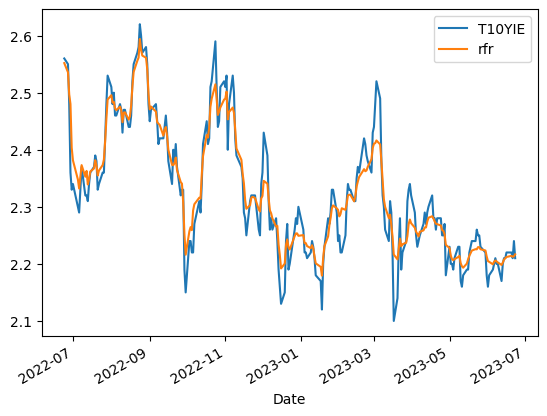

In [ ]:
df_comp=test['T10YIE'].to_frame()
df_comp['rfr']=test_prediction_rfr
df_comp.plot()

In [ ]:
print('Mean squared error: ', mean_squared_error(test['T10YIE'].values, df_comp['rfr'].values))

Mean squared error:  0.0009860215700000178


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
dt=DecisionTreeRegressor(random_state=42,max_features=5)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_features=5, random_state=42)

In [ ]:
n_lag=250
test_prediction_dt=[]
current_batch=get_first_eval_batch(train['T10YIE'].values,n_lag)
for i in range(len(test)):
 current_pred=dt.predict(current_batch)[0]
 test_prediction_dt.append(current_pred)
 current_batch=np.append(current_batch[:,1:],current_pred).reshape(-1,n_lag)
 test_prediction_dt

<Axes: xlabel='Date'>

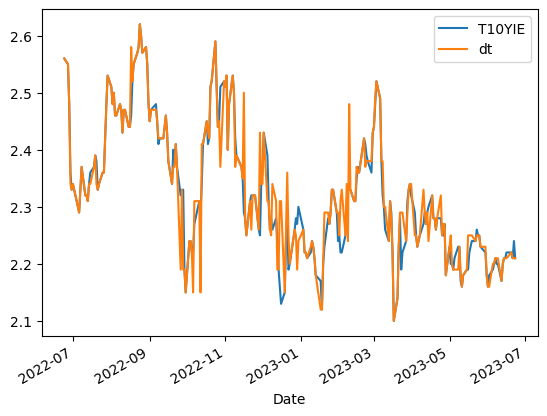

In [ ]:
df_comp=test['T10YIE'].to_frame()
df_comp['dt']=test_prediction_dt
df_comp.plot()

In [ ]:
print('Mean squared error: ', mean_squared_error(test['T10YIE'].values, df_comp['dt'].values))

Mean squared error:  0.0015679999999999993


# XGB Regressor

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(n_estimators = 10, seed = 123)
xgb_r.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
n_lag=250
test_prediction_xgb=[]
current_batch=get_first_eval_batch(train['T10YIE'].values,n_lag)
for i in range(len(test)):
 current_pred=xgb_r.predict(current_batch)[0]
 test_prediction_xgb.append(current_pred)
 current_batch=np.append(current_batch[:,1:],current_pred).reshape(-1,n_lag)

<Axes: xlabel='Date'>

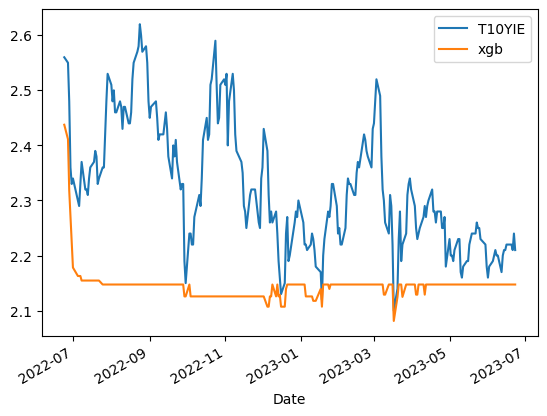

In [ ]:
df_comp=test['T10YIE'].to_frame()
df_comp['xgb']=test_prediction_xgb
df_comp.plot()

In [ ]:
print('Mean squared error: ', mean_squared_error(test['T10YIE'].values, df_comp['xgb'].values))

Mean squared error:  0.04470561857708789


## Ada-Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
ada=AdaBoostRegressor(random_state=42,n_estimators=200)

In [ ]:
ada.fit(X_train,y_train)

AdaBoostRegressor(n_estimators=200, random_state=42)

In [ ]:
n_lag=250
test_prediction_ada=[]
current_batch=get_first_eval_batch(train['T10YIE'].values,n_lag)
for i in range(len(test)):
 current_pred=ada.predict(current_batch)[0]
 test_prediction_ada.append(current_pred)
 current_batch=np.append(current_batch[:,1:],current_pred).reshape(-1,n_lag)
 test_prediction_ada

<Axes: xlabel='Date'>

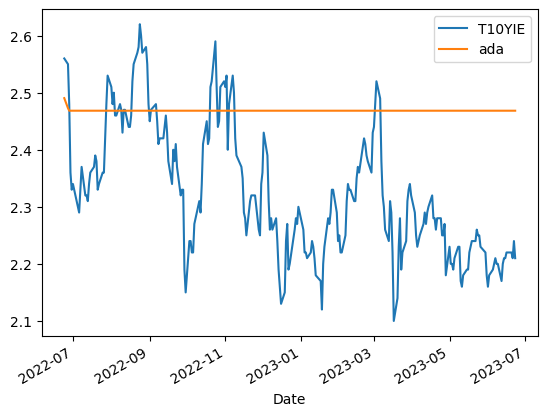

In [ ]:
df_comp=test['T10YIE'].to_frame()
df_comp['ada']=test_prediction_ada
df_comp.plot()

In [ ]:
print('Mean squared error: ', mean_squared_error(test['T10YIE'].values, df_comp['ada'].values))

Mean squared error:  0.0334355356589358
